In [1]:
import functions.data_functions_new as dat
from functions.math_functions import corrected_pulse_area
from functions.plotting_functions import plot_scope

from numpy import divide
import config_file
import os

In [2]:
# import config file dictionary
config = config_file.config_params
config['file'] = r"2301_unlock_HP"
dir = os.path.join(config['root'], config['file'])
# get indexes for data channels in the excel files
di = config['data_indexes']
# make labels from data indexes
labels = {key:di[key] for key in di.keys() if key != 'time'}

In [3]:
# interogate directory to extract folder and file names
folder_list, file_list = dat.dir_interogate(path=dir, extensions=config['extensions'], exceptions=config['exceptions'])
# create dictionary for indexing folders and files
fol_i = dat.make_index_dict(folder_list)
fil_i = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# assemble reference paths
ref_995_path = dat.search_paths(folder_list, file_list, include=config['refs_995'])
ref_1550_path = dat.search_paths(folder_list, file_list, include=config['refs_1550'])
ref_995_path_list = [os.path.join(dir, x) for x in ref_995_path]
ref_1550_path_list = [os.path.join(dir, x) for x in ref_1550_path]
# find polarisation numbers from reference file names
pols_995 = [dat.find_numbers(os.path.split(path)[1], '\d+')[0] for path in ref_995_path]
pols_1550 = [dat.find_numbers(os.path.split(path)[1], '\d+')[0] for path in ref_1550_path]
# extract excel data from the folders
data_path_list = dat.search_paths(folder_list, file_list, config['extensions'])
excel_sets = [[dat.open_csv(os.path.join(dir, data_path)) for data_path in data_paths] for data_paths in data_path_list]

In [4]:
# find index of the polarisation values
tpa_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fol_i.items() if pol in key]
tpa_pol_995 = [value for pol in config['pol_995'] for (key, value) in fol_i.items() if pol in key]
ref_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fil_i[fol_i['1550_solo']].items() if pol in key]
ref_pol_995 = [value for pol in config['pol_995'] for (key, value) in fil_i[fol_i['995_solo']].items() if pol in key]

# create dictionary for index of polarisation max / min - sp is for the folder index, rsp, rcp are for file indexing
tpa_i = {'tpa_sph': tpa_pol_1550[0],
       'tpa_spl': tpa_pol_1550[1]}

pol_i = {'max_sp': ref_pol_1550[0],
         'min_sp': ref_pol_1550[1],
         'max_cp': ref_pol_995[0],
         'min_cp': ref_pol_995[1]}

1550_solo


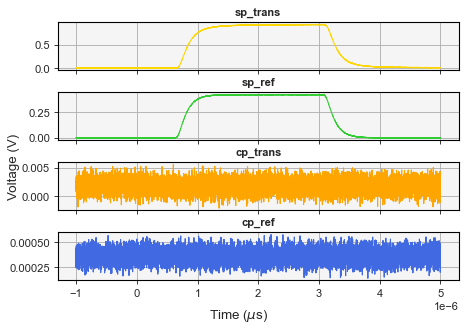

In [5]:
# plot 1550 reference data to check assignment
x = '1550_solo'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

In [ ]:
# plot 995 reference data to check assignment
x = '995_solo'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

In [ ]:
# plot 1550 TPA (absorption high) data to check assignment
name = folder_list[tpa_i['tpa_sph']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

In [ ]:
# plot 1550 TPA (absorption low) data to check assignment
name = folder_list[tpa_i['tpa_spl']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

In [ ]:
# indexes for calculations
area_indexes = [di['cp_trans'], di['cp_ref'], di['time']]
# calculate the normalised reference areas
norm_cph = corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['max_cp']], area_indexes)
norm_cpl = corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['min_cp']], area_indexes)
# corrected pulse ratios: (control pulse - leakage)/ reference
corrected = {'cph_sph': corrected_pulse_area(excel_sets[tpa_i['tpa_sph']][pol_i['max_cp']], area_indexes, excel_sets[fol_i['1550_solo']][pol_i['max_sp']]),
            'cph_spl': corrected_pulse_area(excel_sets[tpa_i['tpa_spl']][pol_i['max_cp']], area_indexes, excel_sets[fol_i['1550_solo']][pol_i['min_sp']]),
            'cpl_sph': corrected_pulse_area(excel_sets[tpa_i['tpa_sph']][pol_i['min_cp']], area_indexes, excel_sets[fol_i['1550_solo']][pol_i['max_sp']]),
            'cpl_spl': corrected_pulse_area(excel_sets[tpa_i['tpa_spl']][pol_i['min_cp']], area_indexes, excel_sets[fol_i['1550_solo']][pol_i['min_sp']])}

# calculate ratio from pulse areas
ratio = {'cph_sph': divide(corrected['cph_sph'], corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['max_cp']], area_indexes)),
        'cph_spl': divide(corrected['cph_spl'], corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['max_cp']], area_indexes)),
        'cpl_sph': divide(corrected['cpl_sph'], corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['max_cp']], area_indexes)),
        'cpl_spl': divide(corrected['cpl_spl'], corrected_pulse_area(excel_sets[fol_i['995_solo']][pol_i['max_cp']], area_indexes))}

# compile data to save as json dict
save_data = {'area' : corrected,
             'ratio' : ratio}

dat.write_json(os.path.join(dir, config['file'] + '.json'), save_data)